## UDP MTU by Probe

This notebook uses RIPE Atlas measurements done by Emile Aben to check differences between ICMP and UDP MTU-dependent connectivity. The basic methodology is as follows:

- Examine MSMS (run by Emile) from N probes to two anchors, over v4 and v6, with different packet sizes.
- Group max MTU for ICMP and UDP per probe, and classify probes according to (1) limited MTU and (2) difference in MTU between UDP and ICMP.

This notebook shares preamble code with [Probe UDP Connectivity](probe_udp_traceconn.ipynb) notebook. This should probably be refactored into a module if we believe we'll keep using it.


### Preamble

Set up the environment and define functions we'll use later.

In [1]:
# Some jupyter magic to set up the environment correctly
%load_ext autoreload
%autoreload 2
%matplotlib inline

# thanks for letting me know about your plans but i don't really care
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# things we need, things to make us go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import warnings
import hashlib
import requests
import os.path
import time
import calendar
import itertools
import json

# HDF5 store for stashing parsed things
store = pd.HDFStore('data_cache/udp_mtu.h5')

##############################################################################
# Probe metadata named tuple and extraction code
##############################################################################
AtlasProbe = collections.namedtuple("AtlasProbe",
           ("pid", "version", "nat", "ip4", "ip6", "asn4", "asn6", "cc", "lat", "lon"))

def extract_atlas_probe(pobj):
    if "address_v4" in pobj:
        ip4 = pobj["address_v4"]
    else:
        ip4 = None

    if "address_v6" in pobj:
        ip6 = pobj["address_v6"]
    else:
        ip6 = None

    if "asn_v4" in pobj:
        asn4 = pobj["asn_v4"]
    else:
        asn4 = None

    if "asn_v6" in pobj:
        asn6 = pobj["asn_v6"]
    else:
        asn6 = None

    if "tags" in pobj:
        if "system-v1" in pobj["tags"]:
            version = 1
        elif "system-v2" in pobj["tags"]:
            version = 2
        elif "system-v3" in pobj["tags"]:
            version = 3
        elif "system-anchor" in pobj["tags"]:
            version = 4
        else:
            version = 0

        nat = "nat" in pobj["tags"]


    return AtlasProbe(pobj["id"], version, nat, ip4, ip6, asn4, asn6,
                      pobj["country_code"], pobj["latitude"], pobj["longitude"])       

def probe_dataframe_from_file(filename="data_cache/all-probes.json"):
    data = []
    
    # make a giant array
    with open(filename) as stream:
        all_probes = json.loads(stream.read())
        for pobj in all_probes["objects"]:
            data.append(extract_atlas_probe(pobj))

    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasProbe._fields)
    
    # indexed by probe ID
    df.index = df['pid']
    del(df['pid'])
    
    # stick an aggregation column on there, we'll use it later
    df['n'] = 1
    
    # and return it
    return df

##############################################################################
# MSM retrieval code
##############################################################################

def get_msm(msm_id, gen, cachedir=None, start=None, stop=None):
    """
    Given an MSM, fetch it from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v1/measurement/%u/result/" % (msm_id,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm_id,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        with open(filepath) as stream:
            yield from gen(json.loads(stream.read()))

    else:
        # just read from the net
        res = requests.get(url, params=params)
        yield from gen(json.loads(res.content.decode("utf-8")))

##############################################################################
# Connectivity sample named tuple,
# connectivity sample generator for use with get_msm(),
# and dataframe creation function wrapping all of this together
##############################################################################

TCSample = collections.namedtuple("TCSample",
                     ("msm_id","time","af","proto","size","pid","sip","dip","reached","hop","rtt"))

def gen_tcs(msm_ary):
    for a_res in msm_ary:        
        if a_res['type'] == 'traceroute':
            if ('result' in a_res):
                maxhop = 0
                maxhop_ok = False
                for hop in a_res['result']:
                    if 'result' in hop:
                        for pkt in hop['result']:
                            if 'from' in pkt:
                                maxhop = hop['hop']
                                if pkt['from'] == a_res['dst_addr']:
                                    maxhop_ok = True
                                    if 'rtt' in pkt:
                                        rtt = pkt['rtt']
                                    else:
                                        rtt = -1
                                    yield TCSample(a_res['msm_id'],
                                           int(a_res['timestamp']), int(a_res['af']), 
                                           a_res['proto'], int(a_res['size']),
                                           a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                           True, maxhop, rtt)
                                    break
                if not maxhop_ok:
                    try:
                        yield TCSample(a_res['msm_id'],
                                       int(a_res['timestamp']), int(a_res['af']), 
                                       a_res['proto'], int(a_res['size']),
                                       a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                       False, maxhop, -1)
                    except KeyError:
                        # ignore completely broken results
                        pass

def tcsample_dataframe(msm_ids, cachedir=None, start=None, stop=None, chunksize=1000000):
    """
    Given an iterable of MSMs, create a dataframe of trace connectivity samples.
    """
    
    # initialize accumulators
    adf = pd.DataFrame([], columns=TCSample._fields)
    data = []
    
    # get individual rows from get_msm
    for msm_id in msm_ids:
        for tcs in get_msm(msm_id, gen=gen_tcs, 
                           start=start, stop=stop, 
                           cachedir=cachedir):
            data.append(tcs)
            
            # Append dataframe to dataframe accumulator if chunking.
            if len(data) >= chunksize:
                adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)
                data = []
                
    # Append final dataframe if non-empty.
    if len(data) > 0:
        adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)

    # Counter column for aggregation
    adf['n'] = 1
    
    return adf

##############################################################################
# Plotting utility function
##############################################################################

def plot_ecdf(a, **kwargs):
    sa = np.sort(a)
    yv = np.arange(len(sa))/float(len(sa))
    plt.plot(sa, yv, **kwargs)

### Step 1b, 2b: store/restore preparsed raw dataframes in HDF

Do this instead of steps 1 and 2 if not reworking parsing and raw dataframs selection. It's silly fast.

In [2]:
# [TODO]
mtudf = store["mtudf"]

### Step 1: retrieve Emile's MSMs

Parse text files listing MSMs committed in the data cache to retrieve MSM numbers, then cache these.

In [ ]:
def msms_from_emile_file(filename):
    with open(filename) as file:
        for line in file:
            d = {k: v for (k,v) in map(lambda x: x.split(":"), line.split())}
            yield int(d["msm_id"])
            
msm_ids = [x for x in msms_from_emile_file("data_cache/emile_mtu_msms_ip4.txt")] + \
          [x for x in msms_from_emile_file("data_cache/emile_mtu_msms_ip6.txt")]
    
%time mtudf = tcsample_dataframe(msm_ids, cachedir="data_cache", chunksize=100000)
store['mtudf'] = mtudf

### Step 2: get connection probability / probe count by AF, protocol

In [3]:
# By connection
conn_per_mtu = {}
for af in (4,6):
    conn_per_mtu[af] = {}
    for proto in ("UDP", "ICMP"):
        apdf = mtudf[(mtudf['af'] == af) & (mtudf['proto'] == proto)]
        conn_per_mtu[af][proto] = apdf.groupby("size")['reached'].sum() / apdf.groupby("size")['n'].sum()  

In [4]:
# By probe (counted if at least one connection)
probes_per_mtu = {}
for af in (4,6):
    probes_per_mtu[af] = {}
    for proto in ("UDP", "ICMP"):
        apdf = mtudf[(mtudf['af'] == af) & (mtudf['proto'] == proto)]
        probes_per_mtu[af][proto] = apdf.groupby(("size", "pid"))['reached'].sum().astype("bool").groupby(axis=0, level=0).sum()

In [5]:
# How many probes in the whole dataset?
len(mtudf.groupby("pid")["n"].sum())

9396

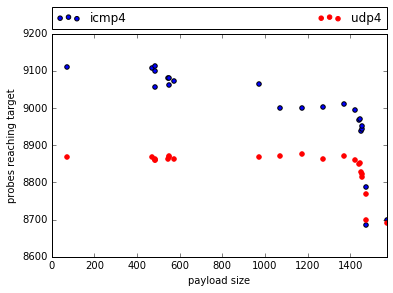

In [6]:
plt.scatter(probes_per_mtu[4]['ICMP'].index.values, probes_per_mtu[4]['ICMP'], label="icmp4")
plt.scatter(probes_per_mtu[4]['UDP'].index.values, probes_per_mtu[4]['UDP'], label="udp4", color="red")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(0,1570)
plt.xlabel("payload size")
plt.ylabel("probes reaching target")
plt.savefig("udp_mtu.pdf")

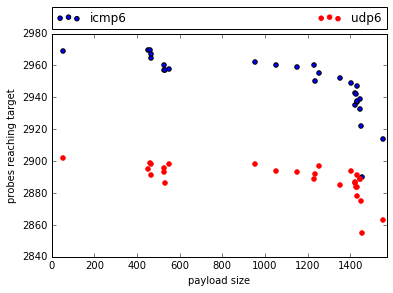

In [7]:
#plt.plot(probes_per_mtu[4]['ICMP'], label="icmp4")
#plt.plot(probes_per_mtu[4]['UDP'], label="udp4")
plt.scatter(probes_per_mtu[6]['ICMP'].index.values, probes_per_mtu[6]['ICMP'], label="icmp6")
plt.scatter(probes_per_mtu[6]['UDP'].index.values, probes_per_mtu[6]['UDP'], label="udp6", color="red")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(0,1570)
plt.xlabel("payload size")
plt.ylabel("probes reaching target")

### Step 3: look for evidence of UDP blocking

In [7]:
# check this data for evidence of UDP blocking

udpdf = mtudf[mtudf['proto'] == "UDP"]
udp_ok_by_pid = udpdf.groupby(("pid"))["reached"].sum()
icmpdf = mtudf[mtudf['proto'] == "ICMP"]
icmp_ok_by_pid = icmpdf.groupby(("pid"))["reached"].sum()

# forget about probes where ICMP didn't work
icmp_broken = icmp_ok_by_pid[icmp_ok_by_pid == 0]
udp_where_icmp_ok = udp_ok_by_pid.loc[udp_ok_by_pid.index.difference(icmp_broken.index)]

# count probes
udp_broken = udp_where_icmp_ok[udp_where_icmp_ok == 0]

print("%5u total probes, %5u may be blocked (%5.2f%%)" % 
      (len(udp_where_icmp_ok), len(udp_broken),
      100 * len(udp_broken) / len(udp_where_icmp_ok)))

 9262 total probes,   296 may be blocked ( 3.20%)


In [17]:
(probes_per_mtu[4]['UDP'] / probes_per_mtu[4]['ICMP'] ).loc[[72, 572, 1454]]

size
72      0.973219
572     0.976854
1454    0.984696
Name: reached, dtype: float64

In [18]:
1 - (probes_per_mtu[4]['UDP'] / probes_per_mtu[4]['ICMP'] ).loc[[72, 572, 1454]]

size
72      0.026781
572     0.023146
1454    0.015304
Name: reached, dtype: float64

In [ ]:
## udp_broken.index.values